In [248]:
# -*- coding: utf-8 -*-
"""
Created on Wed Nov 25 10:32:09 2020

@author: peter fazekas
"""
import os
import csv
import pickle
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import sys
sys.path.append(r'C:\Users\peter fazekas\Desktop\nofakes project\FALdetector-master')
from networks.drn_seg import DRNSeg
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss,BCELoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

import pandas as pd
import numpy as np
import torch.nn as nn
# for reading and displaying images
from skimage.io import imread
# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import data, color
from torchsummary import summary

In [249]:
pathM =r"C:\Users\peter fazekas\Desktop\nofakes project\FALdetector-master\val\modified"
path =r"C:\Users\peter fazekas\Desktop\nofakes project\FALdetector-master\val\reference"

#if you guys can come up with a more efficient way to do this go ahead.
height =300
width=300
#variable to control how many training examples to import
train_size =2
def createTrain(path,n_images):
    arr=[]
    counter =0
    for r,d,f in os.walk(path):
        for _file in f:
            if '.png' in _file:
                #print(_file)
                img = cv2.imread(r""+path+"/"+str(_file))
                #keep image dimensions at 500 for now
                img = cv2.resize(img, (width,height), interpolation = cv2.INTER_AREA)
                #img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
                arr.append(img)
                counter+=1
                #terminate once we imported the desired number of images
                if(counter==n_images):
                    return np.array(arr)
                    

X_ref=createTrain(path,train_size)
X_mod = createTrain(pathM,train_size)
shape = X_ref.shape

In [250]:
flow_arr =[]
#calcOptical gives an error if I input all training data at once (doesnt seem very efficient atm)
for i in range(shape[0]):
    flow = cv2.calcOpticalFlowFarneback(cv2.cvtColor(X_ref[i],cv2.COLOR_BGR2GRAY), cv2.cvtColor(X_mod[i],cv2.COLOR_BGR2GRAY),None, 0.5, 3, 4, 2, 3, 1.2, 0)
    flow_arr.append(flow)
print(X_mod.shape)
flow_arr = np.array(flow_arr)
mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
print(mag.shape)
path = "tester_before_train.png"
tester = save_heatmap_cv(X_mod[0], mag, path)

#print(flow)
print("flow arr has shape",flow_arr.shape)
#the code below is pretty similar to how the binary classifier is trained with a few changes 
#since the output shape is (2,height,width) for the vector field

(2, 250, 250, 3)
(250, 250)
flow arr has shape (2, 250, 250, 2)


In [281]:
#check if GPU is available
if torch.cuda.is_available():
    device = 'cuda:{}'.format(gpu_id)
else:
    device = 'cpu'

model = DRNSeg(2)
state_dict = torch.load("local.pth", map_location=device)
model.load_state_dict(state_dict['model'])
model.to(device)
summary(model, (3, 2, 2))


  


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 16, 2, 2]           2,352
       BatchNorm2d-2             [-1, 16, 2, 2]              32
              ReLU-3             [-1, 16, 2, 2]               0
            Conv2d-4             [-1, 16, 2, 2]           2,304
       BatchNorm2d-5             [-1, 16, 2, 2]              32
              ReLU-6             [-1, 16, 2, 2]               0
            Conv2d-7             [-1, 16, 2, 2]           2,304
       BatchNorm2d-8             [-1, 16, 2, 2]              32
              ReLU-9             [-1, 16, 2, 2]               0
       BasicBlock-10             [-1, 16, 2, 2]               0
           Conv2d-11             [-1, 32, 1, 1]           4,608
      BatchNorm2d-12             [-1, 32, 1, 1]              64
             ReLU-13             [-1, 32, 1, 1]               0
           Conv2d-14             [-1, 3

In [252]:
#changed crossentropy to MSE since cross entropy needs classes, we arent doing classification
#other losses might work much better 
optimizer = Adam(model.parameters(),lr=0.07) 
criterion =torch.nn.MSELoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

    
#convert to torch format
train_x = X_mod
train_x = train_x.reshape(train_size,3, height, width)
print("train_x has shape",train_x.shape)
train_x  = torch.from_numpy(train_x).float()

# converting the target into torch format
train_y=flow_arr


#make sure y_train has the correct shape when feeding it to the network
def get_output_shape(model, image_dim):
    return list(model(torch.rand(*(image_dim))).data.shape)
_,_,w_out,h_out = get_output_shape(model,train_x.shape)

train_y = train_y.reshape(train_size,2,height,width)
train_y = np.resize(train_y,(train_y.shape[0],train_y.shape[1],w_out,h_out))
print("train_y has shape: ",train_y.shape)
train_y = torch.from_numpy(train_y).float()

def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()  
    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    # prediction for training and validation set
    output_train = model(x_train)
    #_,predicted = torch.max(output_train.data,1)
    total = train_size
    
    #correct = (predicted==y_train.long()).sum()
    #acc = 100*correct/total
    
    # computing the training and validation loss
    loss_train = criterion(output_train, y_train.float())
    train_losses.append(loss_train)
    
    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%1 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :',loss_train,"accuracy: ")

train_x has shape (2, 3, 250, 250)
train_y has shape:  (2, 2, 256, 256)


In [267]:
n_epochs = 100
train_losses =[]
correct =0
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : tensor(0.0355, grad_fn=<MseLossBackward>) accuracy: 
Epoch :  2 	 loss : tensor(0.0354, grad_fn=<MseLossBackward>) accuracy: 
Epoch :  3 	 loss : tensor(0.0353, grad_fn=<MseLossBackward>) accuracy: 
Epoch :  4 	 loss : tensor(0.0352, grad_fn=<MseLossBackward>) accuracy: 
Epoch :  5 	 loss : tensor(0.0352, grad_fn=<MseLossBackward>) accuracy: 
Epoch :  6 	 loss : tensor(0.0351, grad_fn=<MseLossBackward>) accuracy: 
Epoch :  7 	 loss : tensor(0.0350, grad_fn=<MseLossBackward>) accuracy: 
Epoch :  8 	 loss : tensor(0.0349, grad_fn=<MseLossBackward>) accuracy: 
Epoch :  9 	 loss : tensor(0.0349, grad_fn=<MseLossBackward>) accuracy: 
Epoch :  10 	 loss : tensor(0.0348, grad_fn=<MseLossBackward>) accuracy: 
Epoch :  11 	 loss : tensor(0.0347, grad_fn=<MseLossBackward>) accuracy: 
Epoch :  12 	 loss : tensor(0.0347, grad_fn=<MseLossBackward>) accuracy: 
Epoch :  13 	 loss : tensor(0.0346, grad_fn=<MseLossBackward>) accuracy: 
Epoch :  14 	 loss : tensor(0.0345, grad_fn=<Ms

In [268]:
def get_heatmap_cv(img, magn, max_flow_mag):
    min_flow_mag = 1
    cv_magn = np.clip(
        255 * (magn - min_flow_mag) / (max_flow_mag - min_flow_mag),
        a_min=0,
        a_max=255).astype(np.uint8)
    if img.dtype != np.uint8:
        img = (255 * img).astype(np.uint8)
        
    heatmap_img = cv2.applyColorMap(cv_magn, cv2.COLORMAP_JET)
    heatmap_img = heatmap_img[..., ::-1]
    h, w = magn.shape
    img_alpha = np.ones((h, w), dtype=np.double)[:, :, None]
    heatmap_alpha = np.clip(
        magn / max_flow_mag, a_min=0, a_max=1)[:, :, None]**.7
    heatmap_alpha[heatmap_alpha < .2]**.5
    pm_hm = heatmap_img * heatmap_alpha
    pm_img = img * img_alpha
    cv_out = pm_hm + pm_img * (1 - heatmap_alpha)
    cv_out = np.clip(cv_out, a_min=0, a_max=255).astype(np.uint8)
    return cv_out

def save_heatmap_cv(img, magn, path, max_flow_mag=2):
    cv_out = get_heatmap_cv(img, magn, max_flow_mag)
    out = Image.fromarray(cv_out)
    plt.imshow(out)
    plt.show()
    out.save(path, quality=95)
    return out

In [269]:
from utils.tools import *
from utils.visualize import *

pic has shape (250, 250, 3)
pic has type <class 'PIL.Image.Image'>


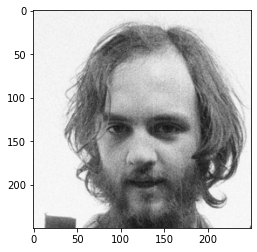

In [270]:
import torchvision.transforms as transforms
tf = transforms.Compose([transforms.ToTensor(),
                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])])
#change path to your training image
#img_path = r"C:\Users\peter fazekas\Desktop\nofakes project\optical-flow\test\flickr_0501m.png"
img_path =r"C:\Users\peter fazekas\Desktop\nofakes project\FALdetector-master\val\modified\flickr_0500.png"
pic = Image.open(img_path).convert('RGB')
#pic = resize_shorter_side(pic, 600)[0]
pic = pic.resize((height,width))

print("pic has shape",np.array(pic).shape)
print("pic has type",type(pic))
plt.imshow(pic)
tens_pic =tf(pic).to(device)

#run picture through model and print the output
with torch.no_grad():
        flow = model(tens_pic.unsqueeze(0))[0].cpu().numpy()
        flow = np.transpose(flow, (1, 2, 0))
        h, w, _ = flow.shape

In [271]:
print(flow.shape)
#print(pic.shape)

(256, 256, 2)


(256, 256, 2)
<class 'PIL.Image.Image'>
(256, 256)


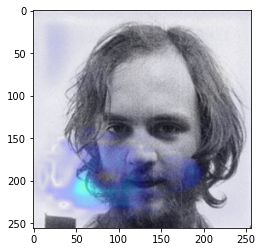

In [278]:
print(flow.shape)

print(type(pic))
modified = pic.resize((w, h),Image.BICUBIC)
modified_np = np.asarray(modified)
flow = flow_resize(flow, modified.size)
mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
print(mag.shape)
#save your image to the folder
path = "tester.png"
tester =get_heatmap_cv(modified_np,mag,max_flow_mag=11)
plt.imshow(tester)